Using device: cuda
Epoch [1/10], Loss: 0.2986500458244015
Epoch [2/10], Loss: 0.08954550199868049
Epoch [3/10], Loss: 0.0550764684620149
Epoch [4/10], Loss: 0.04173716757556095
Epoch [5/10], Loss: 0.03849044128540246
Epoch [6/10], Loss: 0.04486835980787873
Epoch [7/10], Loss: 0.03342168076949961
Epoch [8/10], Loss: 0.024352591594352442
Epoch [9/10], Loss: 0.014346432947444128
Epoch [10/10], Loss: 0.023201449842685285
Test Accuracy: 97.09876543209876%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7479236..2.3585434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.0434113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


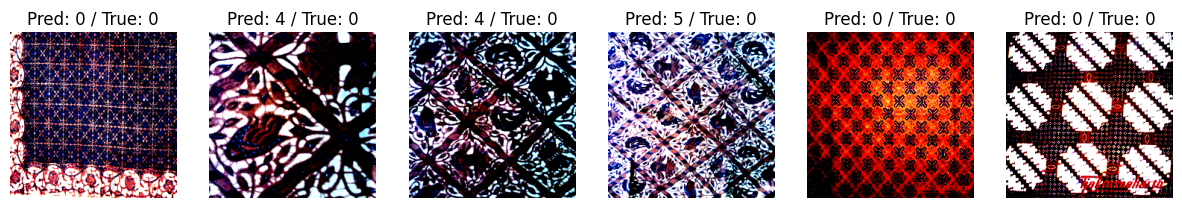

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
train_dir = 'dataset_split/train'  # Directory for training dataset
test_dir = 'test_data'  # Directory for testing dataset

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model (pre-trained ResNet50)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)  # Replace output layer for 6 classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification with soft labels
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert labels to one-hot encoding for multi-label classification
        labels_one_hot = F.one_hot(labels, num_classes=6).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels_one_hot)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# Evaluate on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert labels to one-hot encoding for multi-label classification
        labels_one_hot = F.one_hot(labels, num_classes=6).float()

        outputs = model(inputs)

        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions (multi-label classification)
        preds = (probabilities > 0.5).int()

        # Calculate correct predictions
        correct += (preds == labels_one_hot).sum().item()
        total += labels_one_hot.numel()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Save the model
torch.save(model.state_dict(), "batik_resnet50_model.pth")

# Visualize predictions
def visualize_predictions(loader, n=24):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    model.eval()
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {preds[i].item()} / True: {labels[i].item()}")
        plt.axis("off")
    plt.show()

visualize_predictions(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7479236..2.3585434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.0434113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.39599

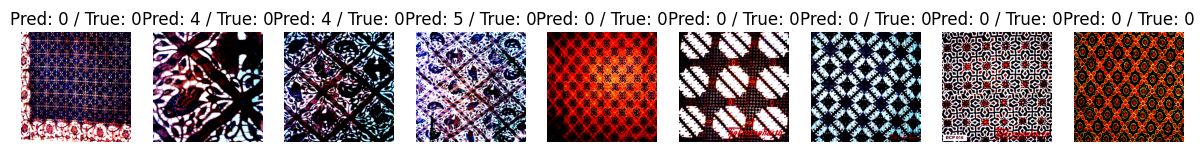

In [25]:
# Visualize predictions
def visualize_predictions(loader, n=9):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    model.eval()
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {preds[i].item()} / True: {labels[i].item()}")
        plt.axis("off")
    plt.show()

visualize_predictions(test_loader)

In [12]:
# Debugging the dataset loader
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i + 1}:")
    print(f"Images shape: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Labels shape: {labels.shape}")  # Should be [batch_size, num_classes]
    print(f"Sample labels: {labels[:5]}")  # Print the first 5 labels in the batch
    break  # Only check the first batch to avoid excessive output

# Check the class-to-index mapping if using ImageFolder
if isinstance(train_dataset, datasets.ImageFolder):
    print("Class-to-Index Mapping:")
    print(train_dataset.class_to_idx)

Batch 1:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Sample labels: tensor([3, 2, 1, 5, 1])
Class-to-Index Mapping:
{'batik-ceplok': 0, 'batik-kawung': 1, 'batik-nitik': 2, 'batik-parang': 3, 'batik-sidoluhur': 4, 'batik-truntum': 5}


Using device: cuda


Epoch 15/15: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, acc=93.8, loss=0.00635]


Training complete and model saved.
Test Accuracy: 96.67%


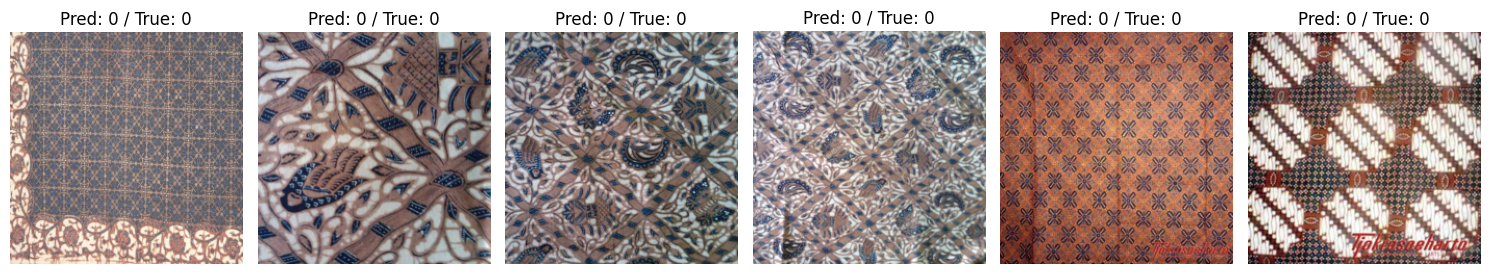

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
batch_size = 32
num_epochs = 15
learning_rate = 0.001
train_dir = "./processed_dataset"
test_dir = "./test_data"

# Simple transforms: only resize + to tensor
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=resize_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=resize_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # 6 Batik classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        loop.set_postfix(loss=running_loss / total, acc=100. * correct / total)

# Save the model
torch.save(model.state_dict(), "resnet50_batik_nomixup_clean.pth")
print("Training complete and model saved.")

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Visualize predictions
def visualize_predictions(loader, n=6):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    model.eval()
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {preds[i].item()} / True: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader)


In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import pandas as pd

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# Parameters
test_dir = "./test_data"
batch_size = 32
model_path = "resnet50_batik_nomixup_clean.pth"
output_csv = "test_predictions.csv"

# Label names (update if needed based on your dataset class folders)
class_names = sorted(os.listdir(test_dir))  # assumes test_data has subfolders per class

# Transforms (same as training: resize + tensor)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset and loader
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 6)  # 6 Batik classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Predict all test images
results = []

sample_index = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        for i in range(imgs.size(0)):
            img_path, _ = test_dataset.samples[sample_index]
            img_filename = os.path.basename(img_path)
            true_class = class_names[labels[i].item()]
            pred_class = class_names[preds[i].item()]
            results.append({
                "filename": img_filename,
                "true_label": true_class,
                "predicted_label": pred_class
            })
            sample_index += 1

# Save to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"Predictions saved to {output_csv}")


Running on: cuda


c:\Users\bdstd\Documents\temp\resnet50-batik-training\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bdstd\Documents\temp\resnet50-batik-training\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


IndexError: list index out of range